**Final Year Project**

**Conducted by: Syed Hammad Javed(F21-0634) & Fahad Akhlaq(F21-0631).**

**Supervised by: Dr Habib Akbar.**

**Preprocessing & Modelling of Pretrained Efficientnetb3 model**

**Importing All Necessary Libraries**

Before building and training our model, we import the essential libraries:

- `pandas` and `numpy` for data manipulation and numerical operations.
- `os` and `shutil` for file and directory management.
- `cv2` (OpenCV) for advanced image preprocessing like cropping, blurring, and contrast enhancement.
- `tqdm` to display progress bars during image processing.
- `train_test_split` from `sklearn.model_selection` for splitting the dataset.
- TensorFlow Keras components:
  - `EfficientNetB3`: Pre-trained CNN model.
  - `Model`, `Dense`, `Dropout`, `GlobalAveragePooling2D`, `Input`: Model and layers for building the custom classifier.
  - `Adam`: Optimizer for training.
  - `ModelCheckpoint`, `EarlyStopping`: Callbacks to improve and monitor training.




In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shutil

**Loading Dataset**

In [ ]:
train_path = '/content/drive/MyDrive/aptos2019/train.csv'

In [ ]:
Train_images = '/content/drive/MyDrive/aptos2019/train_images'

In [ ]:
  train_df = pd.read_csv(train_path)
  train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
test_df = pd.read_csv(test_path)
test_df.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


**Converting Multi-Class to Binary Class and Storing it into Label column**

In [ ]:
train_df['label'] = train_df['diagnosis'].apply(lambda x: 0 if x == 0 else 1)

**Checking Class Distribution and Data Shape**

After converting the diagnosis column into binary labels, it's important to verify the class distribution to check for imbalance.

In [ ]:
print("\nBinary Classification Label Counts:")
print(train_df['label'].value_counts())
train_df.shape


Binary Classification Label Counts:
label
1    1857
0    1805
Name: count, dtype: int64


(3662, 3)

**Splitting the Data into Training and Validation Sets**

In [ ]:
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['label'],
    random_state=42
)

**Extracting Target Labels**

We extract the binary target labels (`label` column) from the training and validation DataFrames. The `.values` function is used to convert the pandas Series into NumPy arrays, which are required by Keras for model training.


In [ ]:
y_train = train_df['label'].values
y_val = val_df['label'].values

In [ ]:
print(f"Training set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")

Training set: (2929, 3)
Validation set: (733, 3)


**PREPROCESSING**

In [ ]:
IMG_SIZE = 300
BATCH = 32
EPOCHS = 20

**Generating Complete Image Paths**

In [ ]:
x_train = [os.path.join(Train_images, f"{img_id}.png") for img_id in train_df['id_code']]
x_val = [os.path.join(Train_images, f"{img_id}.png") for img_id in val_df['id_code']]

**crop_image_from_gray(img, tol=7)**

This function removes the dark background from an image by cropping out low-intensity pixels. It works on both grayscale and RGB images.

- **Grayscale Case**:
  - Applies a brightness mask to retain only meaningful (non-dark) parts of the image.
  - Uses NumPy's `np.ix_` to crop the image rows and columns with at least one bright pixel.

- **RGB Case**:
  - Converts the RGB image to grayscale using OpenCV's `cv2.cvtColor`.
  - Creates a brightness mask and applies it to each of the three RGB channels.
  - If the resulting crop is too small (or empty), it returns the original image.
  - Otherwise, it stacks the three masked channels to reconstruct a cropped RGB image.

This preprocessing is especially useful for medical images (like retina scans) to remove irrelevant background and enhance model focus on the region of interest.


In [ ]:
def crop_image_from_gray(img, tol=7):

    # For Grayscale images
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(axis = 1),mask.any(axis = 0))]

    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #RGB image to grayscale
        mask = gray_img > tol #creates a boolean matrix

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # Whole image is cropped as it was too dark,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(axis = 1),mask.any(axis = 0))] #applies mask to pixel 0
            img2=img[:,:,1][np.ix_(mask.any(axis = 1),mask.any(axis = 0))]
            img3=img[:,:,2][np.ix_(mask.any(axis = 1),mask.any(axis = 0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

**This function prepares raw images for model input by applying several preprocessing steps**

In [ ]:
def preprocess(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted (image, 4, cv2.GaussianBlur(image, (0,0) ,10), -4, 128)
    return image

**We create empty NumPy arrays to store preprocessed images for both training and validation sets.**


In [ ]:
Train_images = np.empty((len(x_train), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
val_images = np.empty((len(x_val), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

In [ ]:
for i, path in enumerate(tqdm(x_train, desc="Preprocessing Train Images")):
    Train_images[i] = preprocess(path)

Preprocessing Train Images: 100%|██████████| 2929/2929 [12:21<00:00,  3.95it/s]


In [ ]:
for i, path in enumerate(tqdm(x_val, desc="Preprocessing Validation Images")):
    val_images[i] = preprocess(path)

Preprocessing Validation Images: 100%|██████████| 733/733 [03:03<00:00,  4.00it/s]


**Checking if the preprocessing is applied on dataset or not**

In [ ]:
Train_images.shape

(2929, 300, 300, 3)

**Model Architecture: Transfer Learning with EfficientNetB3**

In [ ]:
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Load EfficientNetB3 base
efficientnet_model = EfficientNetB3(include_top=False, weights='imagenet', input_tensor=input_layer)


efficientnet_model.trainable = False

x = efficientnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
efficientnet_op = Dense(1, activation='sigmoid')(x)


In [ ]:
efficientnet_model.summary()

Model: "efficientnetb3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,783,535 (41.14 MB)

In [ ]:
ef_model = Model(inputs=input_layer, outputs=efficientnet_op)

In [ ]:
ef_model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
checkpoint = ModelCheckpoint("efficientnetb3_binary_best.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [ ]:
history_ef = ef_model.fit(
    Train_images, y_train,
    validation_data=(val_images, y_val),
    epochs = EPOCHS,
    batch_size=32,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8363 - loss: 0.3342
Epoch 1: val_accuracy improved from -inf to 0.95634, saving model to efficientnetb3_binary_best.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 1125s 12s/step - accuracy: 0.8372 - loss: 0.3329 - val_accuracy: 0.9563 - val_loss: 0.1303
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9509 - loss: 0.1387
Epoch 2: val_accuracy improved from 0.95634 to 0.96589, saving model to efficientnetb3_binary_best.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 1109s 12s/step - accuracy: 0.9509 - loss: 0.1387 - val_accuracy: 0.9659 - val_loss: 0.1100
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9617 - loss: 0.1094
Epoch 3: val_accuracy improved from 0.96589 to 0.96726, saving model to efficientnetb3_binary_best.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 1166s 12s/step - accuracy: 0.9616 - loss: 0.1094 - val_accuracy: 0.9673 - val_loss: 0.0857
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9535 - loss: 0.1312
E

**Evaluation**

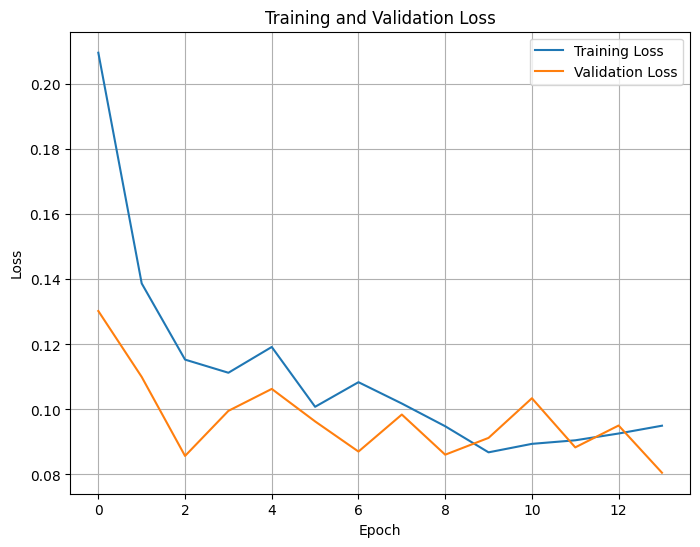

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history_ef.history['loss'], label='Training Loss')
plt.plot(history_ef.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


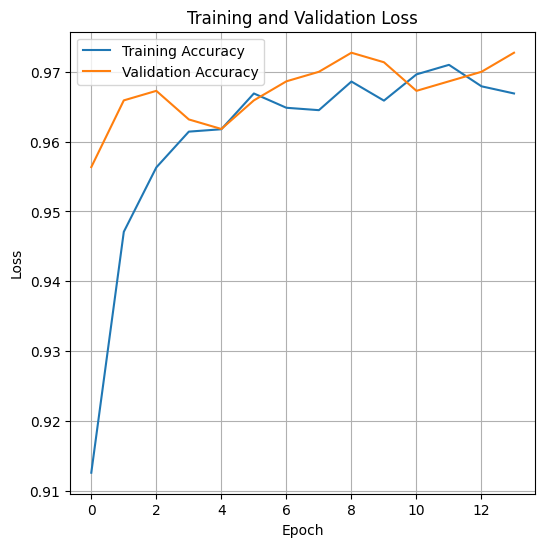

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(history_ef.history['accuracy'], label='Training Accuracy')
plt.plot(history_ef.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_val_probs = ef_model.predict(val_images)
y_val_preds = (y_val_probs > 0.5).astype("int32").reshape(-1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 224s 9s/step


In [ ]:
acc = accuracy_score(y_val, y_val_preds)
kappa = cohen_kappa_score(y_val, y_val_preds)
report = classification_report(y_val, y_val_preds)

In [ ]:
print("Accuracy:", round(acc, 4))
print("Cohen’s Kappa Score:", round(kappa, 4))
print("Classification Report:\n", report)

Accuracy: 0.9727
Cohen’s Kappa Score: 0.9454
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       361
           1       0.97      0.98      0.97       372

    accuracy                           0.97       733
   macro avg       0.97      0.97      0.97       733
weighted avg       0.97      0.97      0.97       733



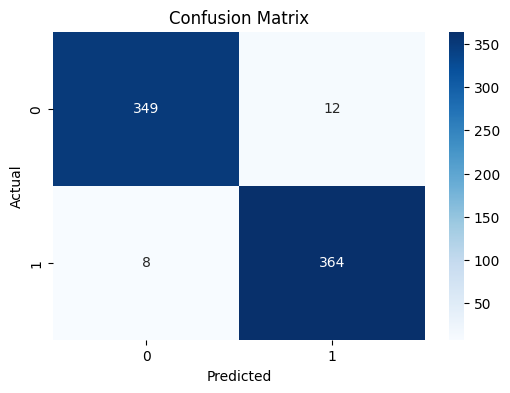

In [ ]:
cm = confusion_matrix(y_val, y_val_preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


<ipython-input-46-83dca034ec9e>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = int(pred[0] > 0.5)  # binary threshold at 0.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


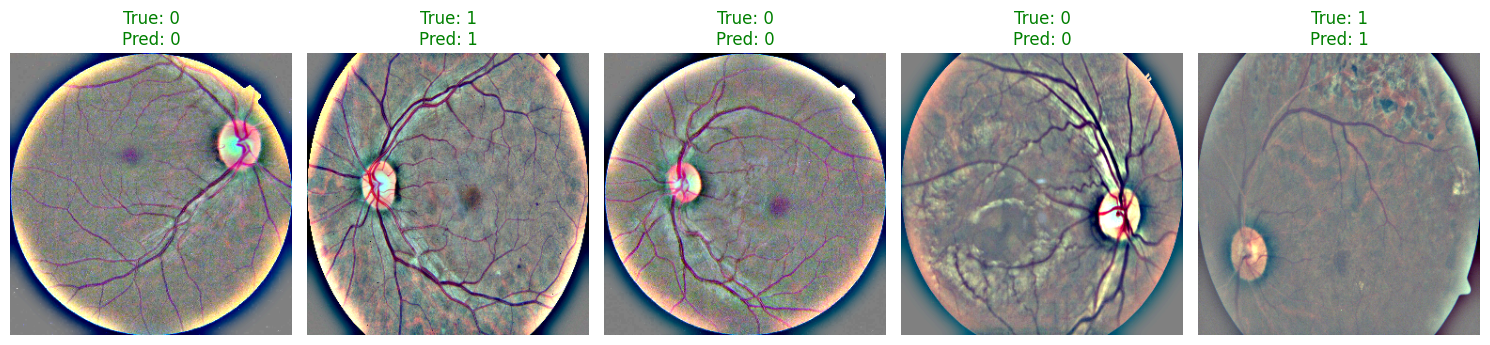

In [ ]:
plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    image_path = x_val[idx]
    true_label = y_val[idx]


    image_data = preprocess(image_path)


    pred = ef_model.predict(np.expand_dims(image_data, axis=0))
    pred_label = int(pred[0] > 0.5)

    # Plot
    plt.subplot(1, num_samples, i+1)
    # Display the preprocessed image data
    plt.imshow(image_data)
    plt.axis('off')
    plt.title(f"True: {true_label}\nPred: {pred_label}",
              color="green" if true_label == pred_label else "red")

plt.tight_layout()
plt.show()

**Model saving**

In [ ]:
save_path = '/content/drive/MyDrive/binary_classification/efficientnetb3_binary_best.keras'

ef_model.save(save_path)

print(f"Model saved successfully at {save_path}")


Model saved successfully at /content/drive/MyDrive/binary_classification/efficientnetb3_binary_best.keras
